In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

%matplotlib inline

In [2]:
#nltk.download('punkt')

In [3]:
data = pd.read_csv("output_merged_25oct.csv", encoding='latin-1')
data.head()

,COMPANY,COUNTRY,DISTRIBUTOR,ARTICLE ID,MODEL NUMBER,ARTICLE NAME,SUBBRAND,SPORTS CATEGORY,PRODUCT DIVISION,PRODUCT GROUP,...,CURRENT PRICE IN EUR,INITIAL PRICE IN SELECTED CURRENCY,CURRENT PRICE IN SELECTED CURRENCY,SELECTED CURRENCY,PRODUCT INTRODUCTION DATE,DISCOUNTED SINCE,PRODUCT EXIT DATE,PRODUCT DESCRIPTION,PRODUCT URL,IMAGE-SERVER URL
0,Nike,USA,Own eCom,837786-603,837786,KD 8 'Aunt Pearl' Premium Big Kids' Basketball...,Performance,Basketball,Footwear,Performance Footwear,...,56.5239,121.80,56.5239,EUR,2/29/2016,11/9/2016,9/18/2017,DYNAMIC VERSATILITY. INSPIRED STYLE.; The KD 8...,https://store.nike.com/us/en_us/pd/kd-8-aunt-p...,http://usporamap287.am.adsint.biz/zoomimages/1...
1,Nike,USA,Own eCom,810455-421,810455,LeBron 13 Transportation Kids' Adjustable Hat,Sport Inspired,Lifestyle,Accessories,Headwear,...,17.3739,24.36,17.3739,EUR,2/29/2016,4/4/2016,5/2/2016,LEBRON TRANSPORTATION HAT The LeBron 13 Transp...,http://store.nike.com/us/en_us/pd/lebron-13-tr...,http://usporamap287.am.adsint.biz/zoomimages/1...
2,Nike,USA,Own eCom,807940-010,807940,Nike SB Cherry Blossom Perforated Trucker Hat,Sport Inspired,Skate,Accessories,Headwear,...,27.8400,27.84,27.8400,EUR,2/29/2016,Not discounted yet,3/21/2016,BREATHABLE COMFORT The Nike SB Cherry Blossom ...,http://store.nike.com/us/en_us/pd/sb-cherry-bl...,http://usporamap287.am.adsint.biz/zoomimages/1...
3,Nike,USA,Own eCom,749502-100,749502,Nike Cortez Big Kids' Shoe,Sport Inspired,Lifestyle,Footwear,Sport Inspired Footwear,...,39.1239,52.20,39.1239,EUR,2/29/2016,2/9/2017,4/10/2017,"A CLASSIC, REBORN. The Nike Cortez BigÂ Kids' ...",http://store.nike.com/us/en_us/pd/cortez-big-k...,http://usporamap287.am.adsint.biz/zoomimages/1...
4,Nike,USA,Own eCom,746735-404,746735,Nike Golf AW84 OX Adjustable Hat,Performance,Golf,Accessories,Headwear,...,17.3739,20.88,17.3739,EUR,2/29/2016,6/30/2016,10/10/2016,PREMIUM LOOK. LIGHTWEIGHT FIT. The Nike Golf A...,http://store.nike.com/us/en_us/pd/golf-aw84-ox...,http://usporamap287.am.adsint.biz/zoomimages/1...


In [4]:
data.isnull().sum()

COMPANY                                    0
COUNTRY                                    0
DISTRIBUTOR                                0
ARTICLE ID                                 0
MODEL NUMBER                               0
ARTICLE NAME                              19
SUBBRAND                                   0
SPORTS CATEGORY                            0
PRODUCT DIVISION                           0
PRODUCT GROUP                              0
PRODUCT TYPE                               0
FRANCHISE                                 20
TECHNOLOGIES                          146388
COLOUR GROUP                               0
COLOUR                                  7285
GENDER                                     0
AGE GROUP                                  0
CONSUMER RATING                            0
INITIAL PRICE IN LOCAL CURRENCY            0
CURRENT PRICE IN LOCAL CURRENCY            0
LOCAL CURRENCY                             0
INITIAL PRICE IN EUR                       0
CURRENT PR

In [5]:
data.COUNTRY.unique()

array(['USA', 'Germany', 'Japan'], dtype=object)

In [6]:
data['GENDER'].unique()

array(['Unisex', 'Male', 'Female'], dtype=object)

In [7]:
# Filtering US and UK
#data = data.loc[data["language"].isin(['de-DE'])]

In [8]:
#data.group.unique()

In [9]:
data_req = data.loc[:,["COMPANY", "COUNTRY", "ARTICLE NAME","PRODUCT TYPE", "PRODUCT DESCRIPTION", "PRODUCT URL"]]

In [10]:
data_req = data_req.drop_duplicates()

In [11]:
len(data_req)

268750

In [12]:
data_req_x = data_req.loc[:,["COMPANY", "COUNTRY", "ARTICLE NAME", "PRODUCT DESCRIPTION", "PRODUCT URL"]]
data_req_y = data_req.loc[:, ["PRODUCT TYPE"]]

In [13]:
data_req_x = data_req_x.fillna("unknown")
data_req = pd.concat([data_req_x, data_req_y], axis=1)

In [14]:
len(data_req)

268750

In [15]:
data_req = data_req.dropna()

In [16]:
data_req = data_req.drop_duplicates()

In [17]:
data_req["description"]  = data_req["COMPANY"] +" " + data_req["COUNTRY"] +" " + data_req["ARTICLE NAME"] +" " + data_req["PRODUCT DESCRIPTION"]+" " + data_req["PRODUCT URL"]

In [18]:
data_req = data_req.drop(["COMPANY", "COUNTRY", "ARTICLE NAME", "PRODUCT DESCRIPTION", "PRODUCT URL"], axis = 1)

In [19]:
data_req.columns = ["subBrand", "description"]

In [20]:
data_req.subBrand.unique()

array(['Basketball', 'Caps', 'Kids Shoes (unisex)', 'Action Sports',
       'Low Cut', 'Golf Bags', 'Swim Equipment', 'Other Sport Equipment',
       'Tools', 'Heads & Beanies', 'High Cut', 'Balls', 'Jump Ropes',
       'Other Bags', 'Middle Cut', 'Artificial Grass & Turf', 'Indoor',
       'Firm Ground', 'Water Bottles', 'Wristbands', 'Sweat & Headbands',
       'Training Sleeves', 'Umbrellas', 'Sport Bags', 'Running/Walking',
       'Legs', 'Backpacks', 'Belts', 'Scarves', 'Golf Clubs',
       'Performance Gloves', 'Shoulder Bags', 'Visors', 'Weights', 'Hats',
       'Track and Field', "Toddler's & Infant's Shoes", 'Training Pants',
       'Unisex Shoes', 'Mobile Accessories', 'Giftsets', 'Lacrosse',
       'Long Sleeve', 'Short Sleeve', 'Mats', 'Power Tubes', 'Training',
       'Jogger', 'Slides & Slippers', 'Sunglasses', 'Wallets',
       'Performance Watches', 'Bandanas', 'Tracksuits', 'Jersey Kits',
       'Shorts', 'Summer Sets', 'Training & Track Jackets', 'Polos',
       'Tenn

In [21]:
len(data_req)

268750

In [22]:
data_req = data_req.drop_duplicates()

In [23]:
data_req.subBrand = data_req.subBrand.str.lower()
data_req.description = data_req.description.str.lower()

In [24]:
data_req.subBrand.unique()

array(['basketball', 'caps', 'kids shoes (unisex)', 'action sports',
       'low cut', 'golf bags', 'swim equipment', 'other sport equipment',
       'tools', 'heads & beanies', 'high cut', 'balls', 'jump ropes',
       'other bags', 'middle cut', 'artificial grass & turf', 'indoor',
       'firm ground', 'water bottles', 'wristbands', 'sweat & headbands',
       'training sleeves', 'umbrellas', 'sport bags', 'running/walking',
       'legs', 'backpacks', 'belts', 'scarves', 'golf clubs',
       'performance gloves', 'shoulder bags', 'visors', 'weights', 'hats',
       'track and field', "toddler's & infant's shoes", 'training pants',
       'unisex shoes', 'mobile accessories', 'giftsets', 'lacrosse',
       'long sleeve', 'short sleeve', 'mats', 'power tubes', 'training',
       'jogger', 'slides & slippers', 'sunglasses', 'wallets',
       'performance watches', 'bandanas', 'tracksuits', 'jersey kits',
       'shorts', 'summer sets', 'training & track jackets', 'polos',
       'tenn

In [25]:
lens = data_req.description.str.len()
lens.mean(), lens.std(), lens.max()

(680.0161227906976, 432.88852932685, 6086)

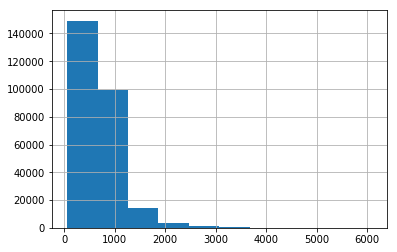

In [26]:
lens.hist();

In [27]:
data_req = data_req.dropna()

In [28]:
len(data_req)

268750

In [29]:
one_hot = pd.get_dummies(data_req.subBrand)

In [30]:
label_cols = data_req.subBrand.dropna().unique()

In [31]:
label_cols

array(['basketball', 'caps', 'kids shoes (unisex)', 'action sports',
       'low cut', 'golf bags', 'swim equipment', 'other sport equipment',
       'tools', 'heads & beanies', 'high cut', 'balls', 'jump ropes',
       'other bags', 'middle cut', 'artificial grass & turf', 'indoor',
       'firm ground', 'water bottles', 'wristbands', 'sweat & headbands',
       'training sleeves', 'umbrellas', 'sport bags', 'running/walking',
       'legs', 'backpacks', 'belts', 'scarves', 'golf clubs',
       'performance gloves', 'shoulder bags', 'visors', 'weights', 'hats',
       'track and field', "toddler's & infant's shoes", 'training pants',
       'unisex shoes', 'mobile accessories', 'giftsets', 'lacrosse',
       'long sleeve', 'short sleeve', 'mats', 'power tubes', 'training',
       'jogger', 'slides & slippers', 'sunglasses', 'wallets',
       'performance watches', 'bandanas', 'tracksuits', 'jersey kits',
       'shorts', 'summer sets', 'training & track jackets', 'polos',
       'tenn

In [32]:
minCount = 10
subBrand_minCount = pd.DataFrame((data_req.subBrand.value_counts() > minCount).reset_index())

In [33]:
subBrand_drop = subBrand_minCount.loc[subBrand_minCount["subBrand"] == False]

In [34]:
subBrand_drop

,index,subBrand
117,torso,False
118,cosmetics,False
119,wetsuits,False
120,grips,False
121,denim shorts,False
122,shoelaces,False


In [35]:
label_cols = np.setdiff1d(label_cols, subBrand_drop["index"])

In [36]:
data_req = pd.concat([data_req, one_hot], axis=1)

In [37]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [38]:
description = "description"

In [39]:
data_req = data_req.drop(subBrand_drop["index"], axis = 1)

In [40]:
np.random.seed(123)
data_req_sample = data_req.sample(frac=0.7)

In [41]:
train = data_req.loc[data_req.index.isin(data_req_sample.index)]
test = data_req.loc[~data_req.index.isin(data_req_sample.index)]

In [42]:
test_subBrand = test.subBrand

In [43]:
#test_subBrand

In [44]:
train = train.drop("subBrand", axis = 1)
test = test.drop("subBrand", axis = 1)

In [45]:
# token_dict = {}
# stemmer = PorterStemmer()

# def stem_tokens(tokens, stemmer):
#     stemmed = []
#     for item in tokens:
#         stemmed.append(stemmer.stem(item))
#     return stemmed

# def tokenize(text):
#     tokens = nltk.word_tokenize(text)
#     stems = stem_tokens(tokens, stemmer)
#     return stems

In [46]:
# from stop_words import get_stop_words
# stop_words_english = get_stop_words('english')
# stop_words_german = get_stop_words('german')

In [47]:
#stop_words_english.append(stop_words_german)

In [48]:
# stop_words_english = sorted(set(map(tuple, stop_words_english)), reverse=True)

In [49]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)
trn_term_doc = vec.fit_transform(train[description])
test_term_doc = vec.transform(test[description])

In [50]:
trn_term_doc, test_term_doc

(<188125x636444 sparse matrix of type '<class 'numpy.float64'>'
 	with 34440039 stored elements in Compressed Sparse Row format>,
 <80625x636444 sparse matrix of type '<class 'numpy.float64'>'
 	with 14613334 stored elements in Compressed Sparse Row format>)

In [51]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [52]:
x = trn_term_doc
test_x = test_term_doc

In [53]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit action sports
fit american football
fit arms
fit artificial grass & turf
fit backpacks
fit balls
fit bandanas
fit baseball
fit basketball
fit bathrobes
fit belts
fit bikinis
fit board shorts
fit boy's shoes
fit capris / skapri
fit caps
fit cardigans
fit coats
fit denim pants
fit dresses
fit female bottoms
fit female tops
fit firm ground
fit freefootball
fit giftsets
fit girl's shoes
fit golf
fit golf bags
fit golf clubs
fit hats
fit head
fit heads & beanies
fit high cut
fit hockey
fit hooded training & track jackets
fit hoodies
fit hoods
fit indoor
fit jersey kits
fit jogger
fit jump ropes
fit jumpsuits
fit kids shoes (unisex)
fit lacrosse
fit legs
fit lifestyle gloves
fit lifestyle watches
fit light jackets
fit long sleeve
fit low cut
fit male bottoms
fit male tops
fit mats
fit men's shoes
fit middle cut
fit mobile accessories
fit other bags
fit other performance shoes
fit other sport equipment
fit others
fit outdoor
fit padded jackets
fit pants
fit performance gloves
fit performa

In [56]:
preds.shape

(80625, 117)

In [57]:
predictions = pd.DataFrame(preds, columns = label_cols)

In [58]:
test.index = np.arange(0, len(test))
test_subBrand.index = np.arange(0, len(test))

In [59]:
len(test)

80625

In [60]:
submid = pd.DataFrame({'description': test["description"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)

In [61]:
submission.head()

,description,action sports,american football,arms,artificial grass & turf,backpacks,balls,bandanas,baseball,basketball,...,umbrellas,unisex shoes,vests,visors,wallets,water bottles,weights,wind jackets,women's shoes,wristbands
0,"nike usa nike cortez big kids' shoe a classic,...",0.000182,0.000032,0.000011,0.000063,0.000067,0.000049,0.000014,0.000027,0.001564,...,0.000012,0.000370,0.000052,0.000036,0.000020,0.000021,0.000010,0.000103,0.008721,0.000035
1,nike germany nike performance low-cut socken f...,0.000103,0.000018,0.000010,0.000053,0.000068,0.000057,0.000011,0.000020,0.000151,...,0.000014,0.000071,0.000078,0.000035,0.000019,0.000022,0.000012,0.000104,0.000023,0.000106
2,nike usa nike jr. tiempo legend vi tf kids' tu...,0.000234,0.000108,0.000018,0.991886,0.000073,0.000082,0.000014,0.000068,0.000484,...,0.000013,0.000322,0.000060,0.000033,0.000020,0.000028,0.000012,0.000112,0.000238,0.000038
3,nike usa nike mercurial victory v tf kids' tur...,0.000125,0.000461,0.000014,0.997604,0.000083,0.000266,0.000018,0.000209,0.000226,...,0.000016,0.000181,0.000063,0.000035,0.000023,0.000022,0.000014,0.000111,0.000050,0.000042
4,nike usa nike jr. mercurial victory v ic kids'...,0.000260,0.000029,0.000014,0.000445,0.000072,0.000280,0.000015,0.000026,0.000823,...,0.000014,0.000190,0.000058,0.000037,0.000022,0.000022,0.000012,0.000099,0.000059,0.000041


In [62]:
final_pred = pd.concat([submission, test_subBrand.str.lower()],axis = 1)

In [63]:
test_subBrand.str.lower().value_counts()

short sleeve                       12503
men's shoes                         5322
running/walking                     5035
shorts                              4774
women's shoes                       3672
training pants                      3316
long sleeve                         2688
tanks & tops                        2485
hooded training & track jackets     2132
hoodies                             2061
training                            2045
caps                                1958
tights                              1923
polos                               1645
training & track jackets            1493
unisex shoes                        1428
firm ground                         1231
sweatshirts                         1164
backpacks                           1161
kids shoes (unisex)                 1123
sport bras                          1117
basketball                          1001
capris / skapri                      948
light jackets                        908
sleeveless      

In [66]:
data["PRODUCT TYPE"].value_counts()

Short Sleeve                       42276
Men's Shoes                        17943
Running/Walking                    16777
Shorts                             16147
Women's Shoes                      12173
Training Pants                     11086
Long Sleeve                         8950
Tanks & Tops                        8259
Hooded Training & Track Jackets     7069
Hoodies                             6865
Training                            6794
Tights                              6526
Caps                                6512
Polos                               5609
Training & Track Jackets            5094
Unisex Shoes                        4592
Firm Ground                         4035
Sweatshirts                         3893
Backpacks                           3863
Kids Shoes (unisex)                 3818
Sport Bras                          3747
Basketball                          3426
Capris / Skapri                     3243
Light Jackets                       3108
Sleeveless      

In [67]:
final_pred["Predictions"] = final_pred[label_cols].idxmax(axis = 1)

In [68]:
from mlxtend.evaluate import confusion_matrix

y_target =    final_pred.subBrand
y_predicted = final_pred.Predictions

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted, 
                      binary=False)

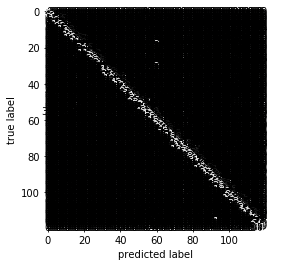

In [69]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [70]:
print(f'Accuracy Score : {accuracy_score(final_pred.subBrand, final_pred.Predictions)}')
print(f'F1 Score: {f1_score(final_pred.subBrand, final_pred.Predictions, average="macro")}')
print(f'Precision: {precision_score(final_pred.subBrand, final_pred.Predictions, average="macro")}')
print(f'Recall: {recall_score(final_pred.subBrand, final_pred.Predictions, average="macro")}')

Accuracy Score : 0.9176806201550387


C:\Users\narendran.thesma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Score: 0.8298311353809656


C:\Users\narendran.thesma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.8655640300498464
Recall: 0.8108086821485031


In [88]:
#final_pred.to_csv("final_output_SubBrand_v4.csv", index_label=False, index=False)

In [83]:
len(final_pred)

20860

In [51]:
#test_subBrand

In [52]:
len(submission)

15062

In [54]:
#final_pred.isnull().sum()